# Descargando el cunjunto de datos


In [1]:
import boto3
import pickle

s3 = boto3.client('s3') #Abre un cliente S3 para aplicar los metodos

bucket = 'sagemaker-sample-files' #Bucket para guardar los datos
s3.download_file(bucket,'datasets/image/MNIST/mnist.pkl', './mnist.pkl') #Ruta para descargar el arichivo 

with open('mnist.pkl', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f) #Descomprime el archivo .pkl y lee train_set, valid_set y test_set

# Visualizando el conjunto de datos cargado

This is a 5


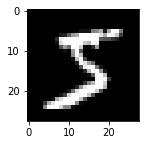

This is a 0


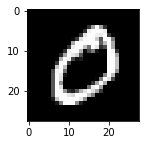

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt #Libreria para graficar

plt.rcParams["figure.figsize"] = (2,10)

#For para mostrar los 2 primeros datos de entrenamiento
for i in range(0, 2):
    img = train_set[0][i] #Imagenes
    label = train_set[1][i] #Etiquetas
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()

# Transformación de datos en CSV y carga al bucket de S3

In [4]:
%%time

import os
import re
import copy
import time
import io
import struct
import numpy as np
from time import gmtime, strftime
import boto3
import sagemaker

role = sagemaker.get_execution_role() #Obteniendo el role de permisos en el usuario de SageMaker

region = boto3.Session().region_name #Obteniendo la región

bucket = sagemaker.Session().default_bucket() #Definiendo el bucket a donde se van a mandar los datos por defecto, este puede cambiar a cualquier otro bucket
prefix = 'sagemaker/xgboost-mnist' #Ruta donde se van a guardar los archivos en el bucket

def convert_data():
    data_partitions = [('train', train_set), ('validation', valid_set), ('test', test_set)]
    for data_partition_name, data_partition in data_partitions:
        print('{}: {} {}'.format(data_partition_name, data_partition[0].shape, data_partition[1].shape)) #Shape saca la dimesion del arreglo
        labels = [t.tolist() for t in data_partition[1]]
        features = [t.flatten().tolist() for t in data_partition[0]]
        
        if data_partition_name != 'test':
            examples = np.insert(features, 0, labels, axis=1)
        else:
            examples = features
            
        np.savetxt('data.csv', examples, delimiter=',') #De np array a CSV
        
        key = "{}/{}/examples".format(prefix,data_partition_name)
        url = 's3://{}/{}'.format(bucket, key)
        boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_file('data.csv')
        print('Done writing to {}'.format(url))
        
convert_data()

train: (60000, 1, 28, 28) (60000,)
Done writing to s3://sagemaker-us-east-2-642758900444/sagemaker/xgboost-mnist/train/examples
validation: (5000, 1, 28, 28) (5000,)
Done writing to s3://sagemaker-us-east-2-642758900444/sagemaker/xgboost-mnist/validation/examples
test: (5000, 1, 28, 28) (5000,)
Done writing to s3://sagemaker-us-east-2-642758900444/sagemaker/xgboost-mnist/test/examples
CPU times: user 1min 6s, sys: 7.21 s, total: 1min 13s
Wall time: 1min 23s


  # Creando y capacitando el modelo mediante el Amazon SageMaker Python SDK

Importando el contenedor xgboost de los algoritmos disponibles en sagemaker

In [7]:
import sagemaker

from sagemaker import image_uris

container = sagemaker.image_uris.retrieve("xgboost", region, "1.2-1") 

Descargando los archivos de entrenamiento subidos al bucket

In [8]:
train_data = 's3://{}/{}/{}'.format(bucket,prefix,'train')

validation_data = 's3://{}/{}/{}'.format(bucket,prefix,'validation')

s3_output_location = 's3://{}/{}/{}'.format(bucket,prefix,'xgboost_model_sdk')
print(train_data)

s3://sagemaker-us-east-2-642758900444/sagemaker/xgboost-mnist/train


Creando una instancia de la clase sagemaker.estimator.Estimator

In [9]:
xgb_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         instance_count=1, 
                                         instance_type='ml.m4.xlarge',
                                         volume_size = 5,
                                         output_path=s3_output_location,
                                         sagemaker_session=sagemaker.Session())

Estableciendo los parametros del algoritmo xgboost

In [10]:
xgb_model.set_hyperparameters(max_depth = 5,
                              eta = .2,
                              gamma = 4,
                              min_child_weight = 6,
                              objective = "multi:softmax",
                              num_class = 10,
                              num_round = 10)

Creando los canales para el entrenamiento

In [11]:
from sagemaker.inputs import TrainingInput

train_channel = TrainingInput(train_data, content_type='text/csv') #train_data, data descargada desde el bucket,TraininInput funcion de sagemaker para configurar canales
valid_channel = TrainingInput(validation_data, content_type='text/csv')

data_channels = {'train': train_channel, 'validation': valid_channel}

Entrenar el Modelo

In [12]:
role = sagemaker.get_execution_role()
print(role)
xgb_model.fit(inputs=data_channels,  logs=True)

arn:aws:iam::642758900444:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole
2021-03-10 16:04:32 Starting - Starting the training job...
2021-03-10 16:04:56 Starting - Launching requested ML instancesProfilerReport-1615392272: InProgress
......
2021-03-10 16:05:56 Starting - Preparing the instances for training......
2021-03-10 16:06:57 Downloading - Downloading input data......
2021-03-10 16:08:00 Training - Training image download completed. Training in progress..[2021-03-10 16:08:03.047 ip-10-0-64-143.us-east-2.compute.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter 

# Implementación del modelo en la nube(No funcional)

In [ ]:
"""import sagemaker
from sagemaker.serializers import CSVSerializer

serializer = StringSerializer(content_type="text/csv")

xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                                #content_type='text/csv',
                                instance_type='ml.t2.medium'
                                serializer=serializer                                 
                                )"""

# Validación del modelo en la nube

In [ ]:
s3 = boto3.resource('s3')

test_key = "{}/test/examples".format(prefix)

s3.Bucket(bucket).download_file(test_key, 'test_data')

In [ ]:
%matplotlib inline
                        
for i in range (0, 2):
    img = test_set[0][i]
    label = test_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()

In [ ]:
"""with open('test_data', 'r') as f:
    for j in range(0,10):
        single_test = f.readline()
        result = xgb_predictor.predict(single_test)
        print(result)"""

# Implementacion del modelo por Lotes

In [13]:
# batch_input recibe los datos de prueba ubicados en el bucket
batch_input = 's3://{}/{}/test/examples'.format(bucket, prefix)

# batch_output es la salida de estos datos transformados en bloques
batch_output = 's3://{}/{}/batch-inference'.format(bucket, prefix)

#Se define un transformer
transformer = xgb_model.transformer(instance_count=1, instance_type='ml.m4.xlarge', output_path=batch_output)

transformer.transform(data=batch_input, data_type='S3Prefix', content_type='text/csv', split_type='Line')

transformer.wait()

...............................[2021-03-10:16:20:06:INFO] No GPUs detected (normal if no gpus installed)
[2021-03-10:16:20:06:INFO] No GPUs detected (normal if no gpus installed)
[2021-03-10:16:20:06:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }

    location / {
      return 404 "{}";
    }

  }
}


[2021-03-10 16:20:06 +0000] [17] [INFO] St

# Validación del modelo por Lotes

In [14]:
s3 = boto3.resource('s3')

test_key = "{}/test/examples".format(prefix)

s3.Bucket(bucket).download_file(test_key, 'test_data')

This is a 3


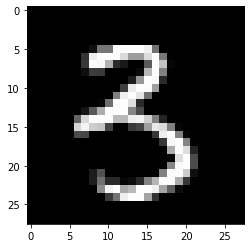

This is a 9


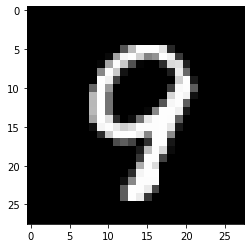

This is a 9


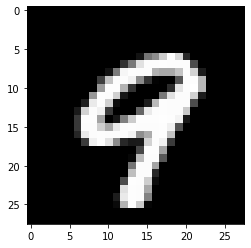

This is a 8


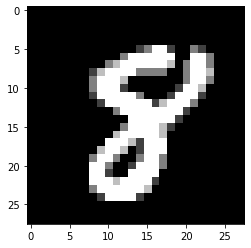

This is a 4


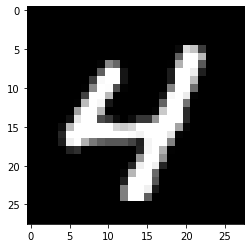

This is a 1


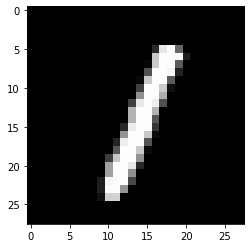

This is a 0


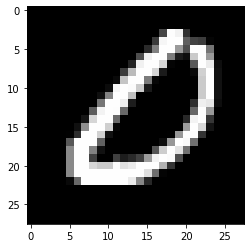

This is a 6


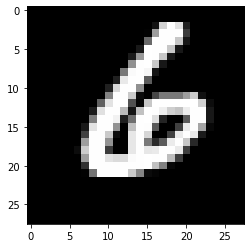

This is a 0


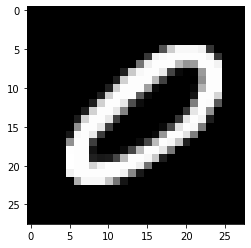

This is a 9


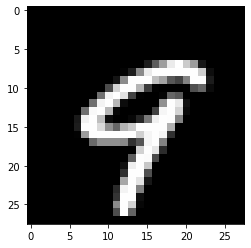

In [15]:
%matplotlib inline
                    
for i in range (0, 10):
    img = test_set[0][i]
    label = test_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()

In [16]:
#Se descargan los datos entrenados
s3.Bucket(bucket).download_file(prefix + '/batch-inference/examples.out',  'batch_results')

In [17]:
with open('batch_results') as f:
    results = f.readlines()
for j in range (0, 10):
    print(results[j])

3.0

9.0

9.0

8.0

4.0

1.0

0.0

6.0

0.0

4.0

